In [1]:
# Baixar biblioteca
!pip install imutils


In [2]:
# Importar pacotes

# Importando as bibliotecas de modelo
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau

# Importando as bibliotecas padrões
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from imutils import paths
import seaborn as sns


# Importando a biblioteca para carregar arquivos do drive
from google.colab import drive

Build Dataset


In [3]:
# drive.mount("/content/drive/", force_remount=True)

In [4]:
# dataset_path='/content/drive/MyDrive/dataset'

# normal_images = list(paths.list_images(f"{dataset_path}/normal"))
# covid_images = list(paths.list_images(f"{dataset_path}/covid"))

In [5]:
! git clone https://github.com/michelleamesquita/puc-mvp-3.git

fatal: destination path 'puc-mvp-3' already exists and is not an empty directory.


In [6]:
dataset_path='/content/puc-mvp-3/dataset'

normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

Dataset de Raio-X de Imagens com/sem COVID-19

In [7]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)

    # for i in range(len(imspaths)):
    sp = f.add_subplot(2, 1, 1)
    sp.axis('Off')
    if titles is not None: sp.set_title(titles[1], fontsize=16)
    img = plt.imread(imspaths[1])
    plt.imshow(img)

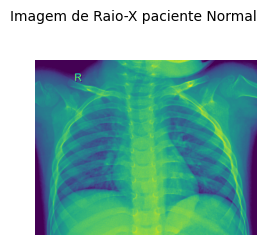

In [8]:
plots_from_files(normal_images, rows=5, maintitle="Imagem de Raio-X paciente Normal")


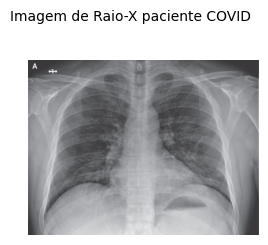

In [9]:
plots_from_files(covid_images, rows=5, maintitle="Imagem de Raio-X paciente COVID")

Processamento de dados

In [10]:
# Iniciando o aprendizado com taxa, numero de epocas e tamanho

INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [11]:
# Carregando imagens do dataset

print("[INFO] Carregando imagens...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

# Loop nas epocas
for imagePath in imagePaths:

    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)

# Converter o dado para array Numpy
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] Carregando imagens...


In [12]:
# Encodar as labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Dividindo os dados para treinar usando 20% e 80% para testes
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

# Iniciando o treinamento
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest" )

Visualizaçao de dados

<Axes: xlabel='count'>

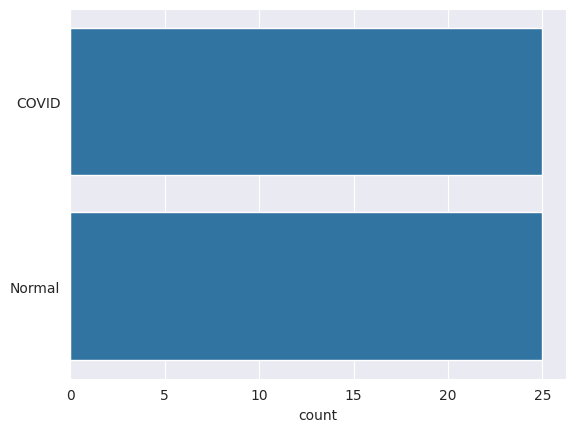

In [13]:
l = []
for i in labels:
    if(i[1] == 0):
        l.append("COVID")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Distribuicao dos dados


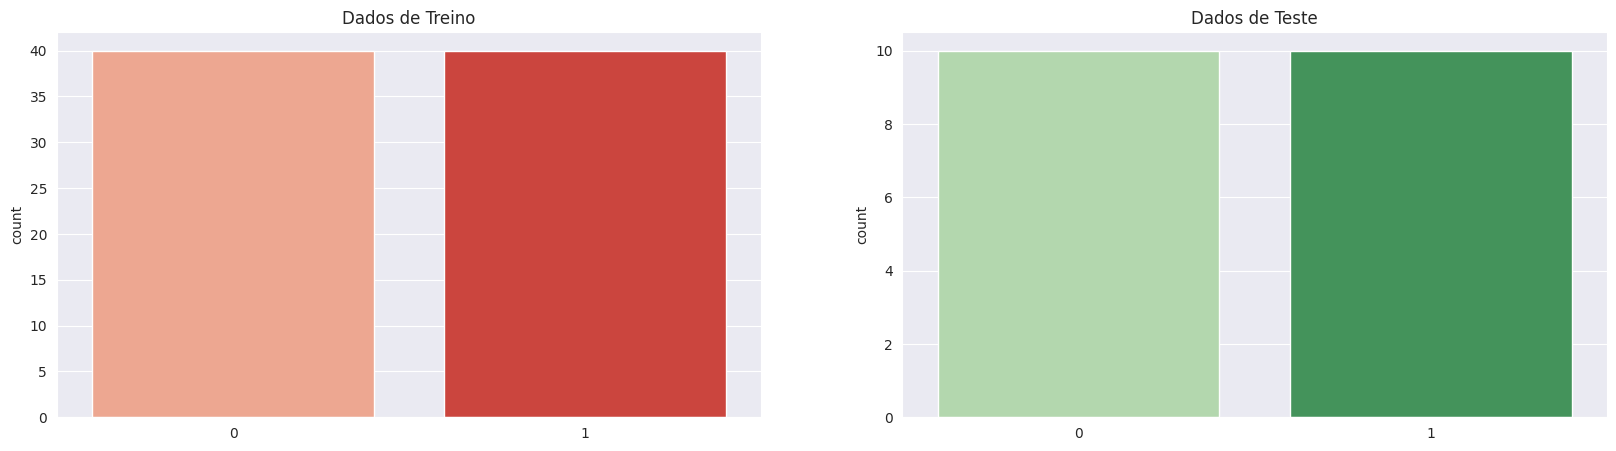

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(trainY, ax=ax[0], palette="Reds")
ax[0].set_title("Dados de Treino")
sns.countplot(testY, ax=ax[1], palette="Greens");
ax[1].set_title("Dados de Teste");

Model

In [15]:
# Carregando a rede VGG16
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construindo modelo
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

Training

In [16]:
# Usar modelo
print("[INFO] Compilando modelo...")
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Treinar o modelo
print("[INFO] Treinando o modelo...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] Compilando modelo...
[INFO] Treinando o modelo...
Epoch 1/10


<ipython-input-16-212fcf914a85>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


5/5 [==============================] - 59s 12s/step - loss: 0.7288 - accuracy: 0.5250 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/10
5/5 [==============================] - 34s 7s/step - loss: 0.7344 - accuracy: 0.5250 - val_loss: 0.6684 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 35s 7s/step - loss: 0.6809 - accuracy: 0.6250 - val_loss: 0.6553 - val_accuracy: 0.6000
Epoch 4/10
5/5 [==============================] - 35s 7s/step - loss: 0.6759 - accuracy: 0.5250 - val_loss: 0.6472 - val_accuracy: 0.9000
Epoch 5/10
5/5 [==============================] - 30s 6s/step - loss: 0.6351 - accuracy: 0.6500 - val_loss: 0.6416 - val_accuracy: 0.8000
Epoch 6/10
5/5 [==============================] - 37s 8s/step - loss: 0.6778 - accuracy: 0.5750 - val_loss: 0.6355 - val_accuracy: 0.8000
Epoch 7/10
5/5 [==============================] - 35s 7s/step - loss: 0.6586 - accuracy: 0.6000 - val_loss: 0.6295 - val_accuracy: 0.9000
Epoch 8/10
5/5 [============================

In [17]:
print("Loss of the model is - " , model.evaluate(testX,testY)[0])
print("Accuracy of the model is - " , model.evaluate(testX,testY)[1]*100 , "%")

1/1 [==============================] - 6s 6s/step - loss: 0.6117 - accuracy: 0.8000
Loss of the model is -  0.611723005771637
1/1 [==============================] - 5s 5s/step - loss: 0.6117 - accuracy: 0.8000
Accuracy of the model is -  80.0000011920929 %


Plotar métricas de treinamento

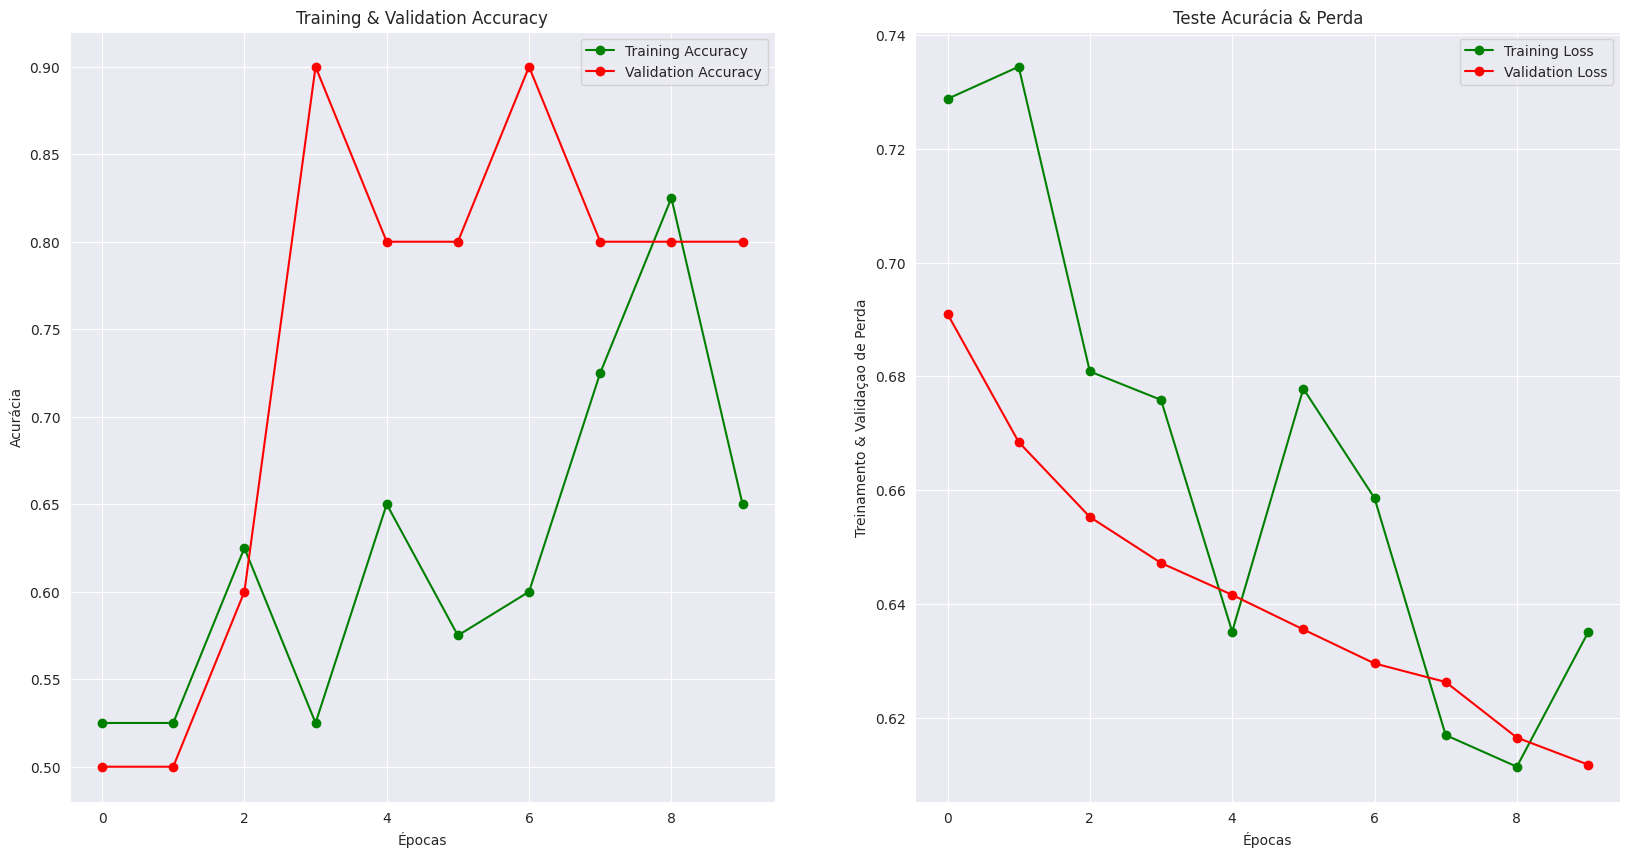

In [18]:
# Plotar treinamento de perda e acurácia

N = EPOCHS
fig , ax = plt.subplots(1,2)
train_acc = H.history['accuracy']
train_loss = H.history['loss']
val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(np.arange(0, N) , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(np.arange(0, N) , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

ax[1].plot(np.arange(0, N) , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(np.arange(0, N) , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Teste Acurácia & Perda')
ax[1].legend()
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Treinamento & Validaçao de Perda")
plt.show()

Avaliaçao de Rede

In [19]:
print("[INFO] Avaliaçao de Rede...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

# Report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] Avaliaçao de Rede...
2/2 [==============================] - 7s 1s/step
              precision    recall  f1-score   support

       covid       0.71      1.00      0.83         5
      normal       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



Matriz de confusao

In [20]:
# Usar para acurácia,  accuracy, sensibilidade e especificidade
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [2 3]]
acc: 0.8000
sensitivity: 1.0000
specificity: 0.6000


In [21]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])


<Axes: >

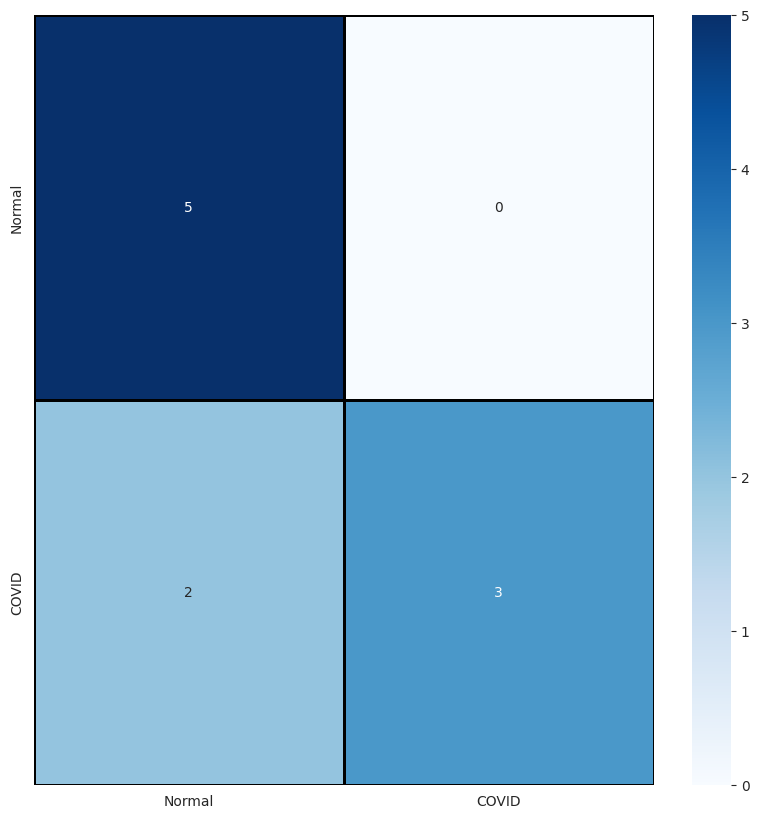

In [22]:
plt.figure(figsize = (10,10))
ll=['Normal','COVID']
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ll,yticklabels = ll)

In [23]:
correct = np.nonzero(predIdxs == testY.argmax(axis=1))[0]
incorrect = np.nonzero(predIdxs != testY.argmax(axis=1))[0]

In [24]:
print(correct,incorrect)

[0 2 4 5 6 7 8 9] [1 3]


Algumas classes corretas

<ipython-input-25-5b663675569b>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


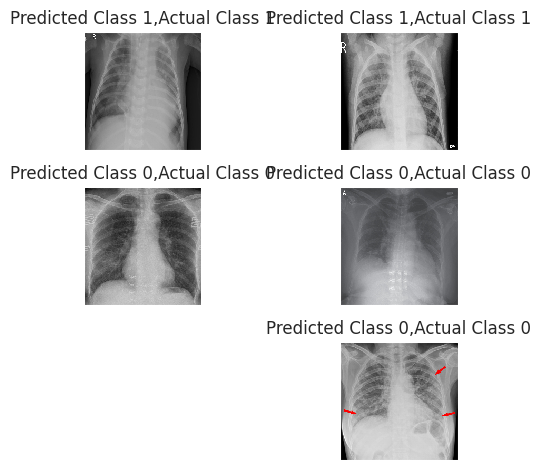

In [25]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testX[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predIdxs[c], testY.argmax(axis=1)[c]))
    plt.tight_layout()
    i += 1

Algumas classes incorretas

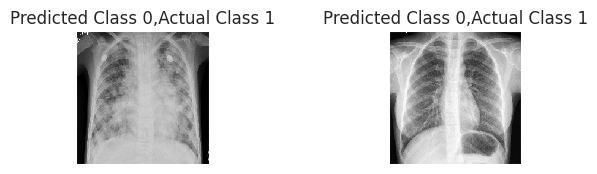

In [26]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(testX[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predIdxs[c], testY.argmax(axis=1)[c]))
    plt.tight_layout()
    i += 1

Conclusão

- É possível perceber que ao utilizar a rede VGG16 foi excelente para classificar as imagens
- Foi possível obter uma acurácia de 80%